In [1]:
# 图像配准Step1，后面再给它整合到一个类中
import cv2
import numpy as np
import matplotlib.pyplot as plt
from image_enhanced.image_preprocess import ImageProcess
from utils.tools import Tools
from utils.visualize import VisualizeData

config = Tools.load_yaml_config("preprocess_config.yaml")

imageProcess = ImageProcess(config)

root_path = "G:/CT/4/Reconstruction"
save_path = "D:/workspace/ml-workspace/registration/datasets/sample4/bse/s2/100"
file_name = "4-1-1"

file_path = f"{root_path}/4-_IR_rec00000590.bmp"
ct_img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)

enhanced_ct = ct_img#imageProcess.enhanced_ct(ct_img)
cls_ct = imageProcess.segment_ct(enhanced_ct, 5, 256)

cv2.imwrite(f'{save_path}/{file_name}-ct-segment.bmp', cls_ct)
cv2.imwrite(f'{save_path}/{file_name}-ct-enhanced.bmp', enhanced_ct)

plt.figure(figsize=(20, 20))
plt.subplot(2, 2, 1), plt.imshow(enhanced_ct, cmap='gray',vmin=0, vmax=255), plt.title('kms')
plt.subplot(2, 2, 2), plt.imshow(cls_ct, cmap='gray',vmin=0, vmax=255), plt.title('kms')
plt.subplot(2, 2, 3), plt.imshow(ct_img, cmap='gray',vmin=0, vmax=255), plt.title('kms')


FileNotFoundError: [Errno 2] No such file or directory: 'd:\\workspace\\ml-workspace\\registration\\implement\\preprocess_config.yaml'

(<Axes: title={'center': 'filtered_image'}>,
 Text(0.5, 1.0, 'filtered_image'))

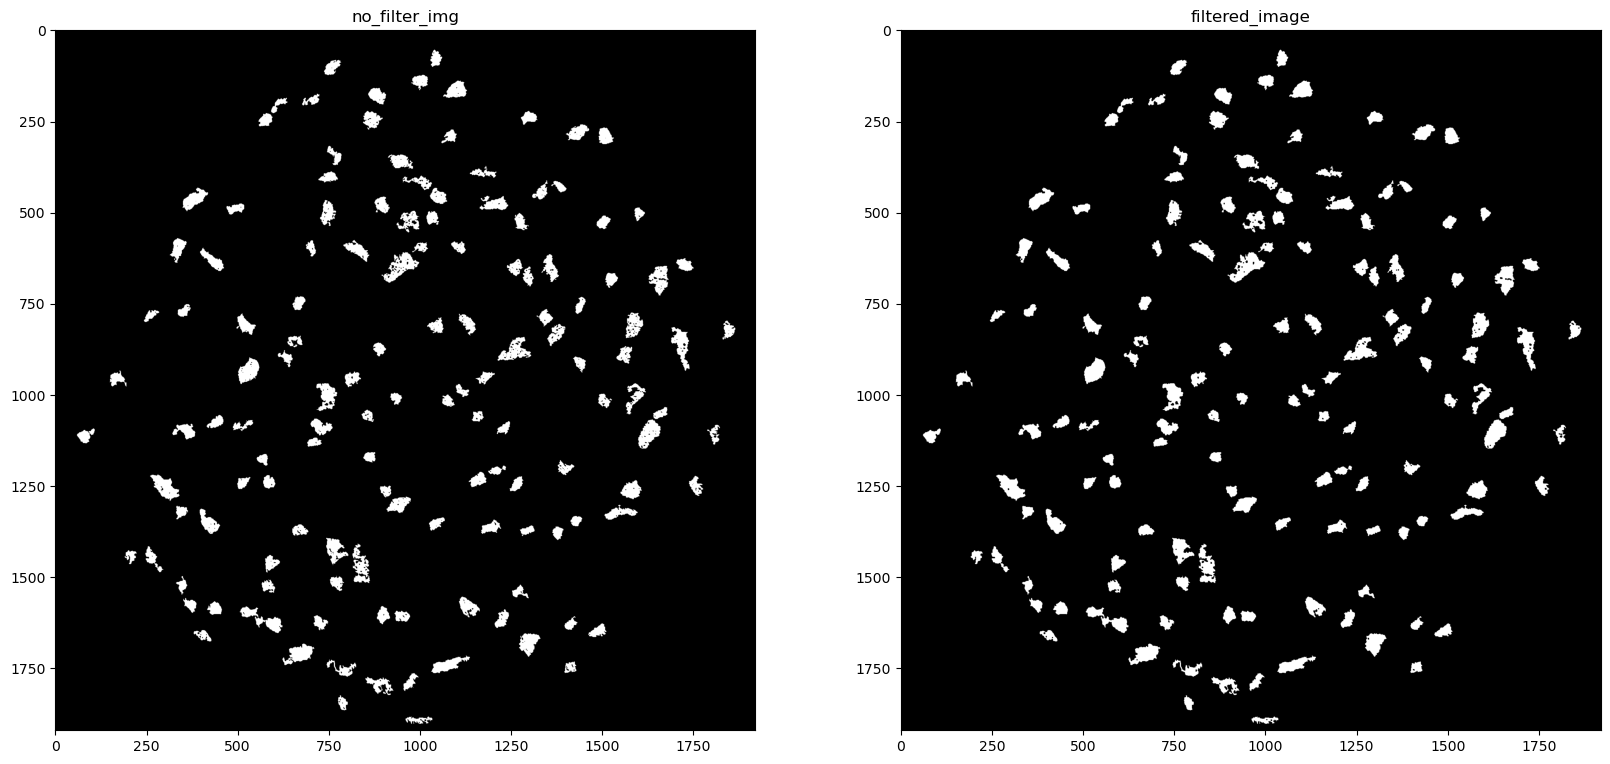

In [8]:
gray_cls = 63

kms = cls_ct.copy()

neg_cls = kms != gray_cls
positive_cls = kms == gray_cls
kms[neg_cls] = 0
kms[positive_cls] = 255

bin_image = kms

# 寻找连通区域
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(bin_image, 4, cv2.CV_32S)

# 设置大小阈值
size_threshold = 624

# 创建一个新的图像来存放结果
new_image = np.zeros_like(bin_image)

# 遍历所有连通区域
for i in range(1, num_labels):
    if stats[i, cv2.CC_STAT_AREA] >= size_threshold:
        # 如果连通区域的大小大于阈值，则将其添加到新图像中
        new_image[labels == i] = 255

no_filter_img = np.copy(new_image)

kms = new_image
# 定义核（kernel）的大小
kernel_size = 3
kernel = np.ones((kernel_size, kernel_size), np.uint8)

# 膨胀操作
dilated_image = cv2.dilate(kms, kernel, iterations=1)

# 腐蚀操作
eroded_image = cv2.erode(dilated_image, kernel, iterations=1)
new_image = eroded_image

cv2.imwrite(f'{save_path}/{file_name}-ct-masked.bmp', new_image)

plt.figure(figsize=(20, 20))
plt.subplot(2, 2, 1), plt.imshow(no_filter_img, cmap='gray',vmin=0, vmax=255), plt.title('no_filter_img')
plt.subplot(2, 2, 2), plt.imshow(new_image, cmap='gray',vmin=0, vmax=255), plt.title('filtered_image')

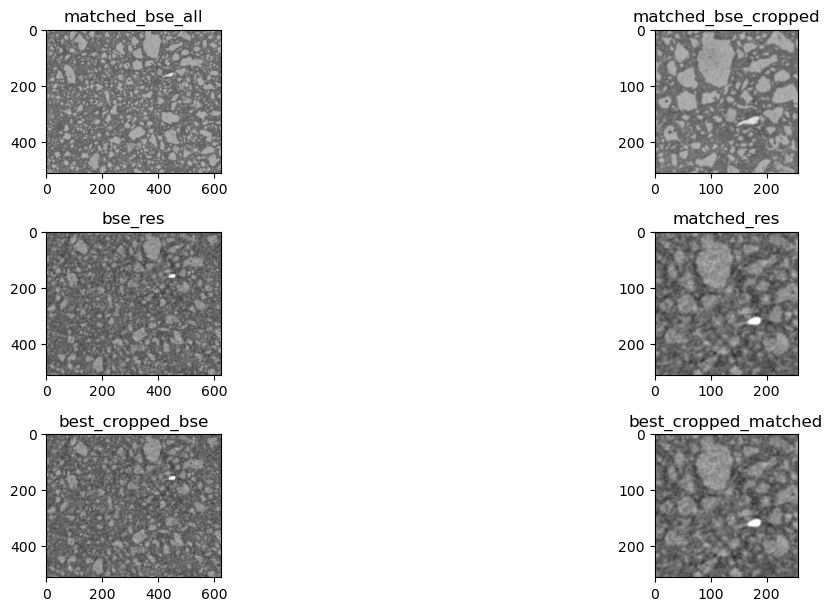

In [4]:
best_ct_img = Tools.get_ct_img(config.cement_sample_index, best_cropped_index)
best_cropped_matched_res = Tools.crop_rotate_mi(ct_img, 
                                   [ct_size[0] * 0.5, ct_size[0] * 0.5],
                                   ct_size,
                                   config.matched_rotation,
                                   matched_cropped_rect
                                   )
best_cropped_bse_res = Tools.crop_rotate_mi(ct_img, 
                                   [ct_size[0] * 0.5, ct_size[0] * 0.5],
                                   ct_size,
                                   config.matched_rotation,
                                   matched_bse_rect
                                   )

VisualizeData.show_imgs([matched_bse_img, matched_bse_cropped_img, 
                         cropped_bse_res, cropped_matched_res,
                           best_cropped_bse_res, best_cropped_matched_res], 
                           ["matched_bse_all", "matched_bse_cropped", 
                            "bse_res", "matched_res",
                            "best_cropped_bse", "best_cropped_matched"])

(<Axes: title={'center': 'fill_img'}>,
 Text(0.5, 1.0, 'fill_img'))

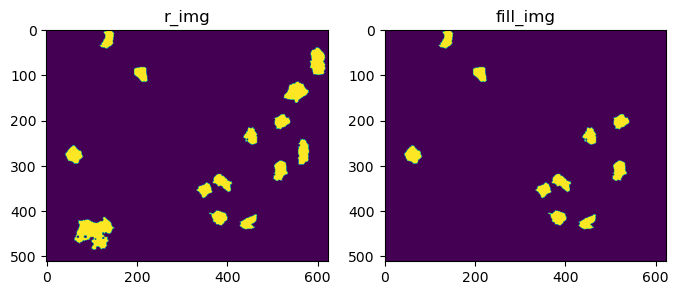

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

r_path = "D:/workspace/ml-workspace/registration/datasets/sample5/bse/s1/100/5-1-1-roi-mask.bmp"
r_img = cv2.imread(r_path, cv2.IMREAD_GRAYSCALE)

fill_img = np.copy(r_img)

# 寻找连通区域
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(fill_img, 4, cv2.CV_32S)

# 定义需要保留的面积范围
min_area = 624  # 最小面积
max_area = 1000  # 最大面积

def filter_img(img, min, max):
    # 遍历每个联通区域
    for i in range(1, num_labels):
        area = stats[i, cv2.CC_STAT_AREA]
        if area < min or area > max:
            # 如果面积不在指定范围内，将该区域填充为背景色
            img[labels == i] = 0
    return img

fill_img = filter_img(fill_img, min_area, max_area)


plt.figure(figsize=(8, 8))
cols, rows = 2, 1
plt.subplot(rows, cols, 1), plt.imshow(r_img), plt.title('r_img')
plt.subplot(rows, cols, 2), plt.imshow(fill_img), plt.title('fill_img')



In [21]:
import numpy as np
import math

latent_depth = 50
slice_width, slice_height = 256, 512

tan_theta = latent_depth / (slice_width*0.5)
sin_theta = latent_depth / slice_height

radians_height = math.asin(sin_theta)
degree_height = math.degrees(radians_height)

radians_width = math.asin(tan_theta)
degree_width = math.degrees(radians_width)



print(f"theta_width: {degree_width}, theta_height: {degree_height}")


import numpy as np
from scipy.interpolate import interpn

def interpolate_ct_image(ct_image, points):
    """
    对CT图像在给定点进行插值。
    
    参数:
    ct_image -- 三维CT图像，形状为 (depth, height, width)
    points -- 要进行插值的点，形状为 (n_points, 3)
    
    返回:
    values -- 插值后的值，形状为 (n_points,)
    """
    # 定义网格点的坐标
    depth, height, width = ct_image.shape
    grid_z, grid_y, grid_x = np.arange(depth), np.arange(height), np.arange(width)
    grid = (grid_z, grid_y, grid_x)
    
    # 将索引点限制在数据的边界内
    points = np.clip(points, [0, 0, 0], np.array(ct_image.shape) - 1)
    
    # 使用三线性插值
    values = interpn(grid, ct_image, points, method='linear', bounds_error=False, fill_value=None)
    return values

# 创建一个示例三维CT图像
depth, height, width = 100, 200, 300
ct_image = np.random.rand(depth, height, width)

# 定义一个任意方向的索引数组
# 例如，沿着对角线方向的索引
z = np.linspace(0, depth - 1, num=50)
y = np.linspace(0, height - 1, num=50)
x = np.linspace(0, width - 1, num=50)
indices = np.vstack((z, y, x)).T

# 对索引数组进行变换
# 这里仅作示例，实际变换方式可能根据具体需求有所不同
transformed_indices = indices + np.random.rand(*indices.shape) * 0.5
indices_forced = transformed_indices.astype(np.uint16)

ori_values = ct_image[indices_forced[..., 0], indices_forced[..., 1], indices_forced[..., 2]]

# 对变换后的索引数组进行插值
interpolated_values = interpolate_ct_image(ct_image, transformed_indices)

print("变换后的索引:")
print(transformed_indices)

print("原始的值:")
print(ori_values)
print("插值后的值:")
print(interpolated_values)



theta_width: 22.993394314297802, theta_height: 5.604222828286625
变换后的索引:
[[2.68608651e-01 3.03651000e-01 4.18231462e-02]
 [2.27275516e+00 4.25011934e+00 6.42514656e+00]
 [4.53688167e+00 8.37399311e+00 1.26989052e+01]
 [6.12597442e+00 1.23648967e+01 1.83370617e+01]
 [8.40341099e+00 1.63615102e+01 2.48031635e+01]
 [1.03642916e+01 2.03644880e+01 3.07690200e+01]
 [1.25473675e+01 2.47474492e+01 3.68419023e+01]
 [1.42306379e+01 2.85161725e+01 4.31223276e+01]
 [1.62239704e+01 3.29267105e+01 4.90371661e+01]
 [1.83124806e+01 3.66986318e+01 5.54164072e+01]
 [2.05225243e+01 4.11012319e+01 6.14125317e+01]
 [2.26319747e+01 4.48620199e+01 6.74881676e+01]
 [2.43794653e+01 4.89694749e+01 7.32308404e+01]
 [2.66522361e+01 5.29780240e+01 7.96901617e+01]
 [2.86764800e+01 5.73333534e+01 8.58495715e+01]
 [3.07075122e+01 6.12755773e+01 9.16875896e+01]
 [3.24506251e+01 6.53062740e+01 9.78644390e+01]
 [3.48062623e+01 6.94028021e+01 1.03825797e+02]
 [3.65008393e+01 7.31602427e+01 1.10203072e+02]
 [3.88088021e+0

aim_dist_diameter: [28, 75]
mean diamter1: 5.55928305657419
mean diamter2: 5.55928305657419


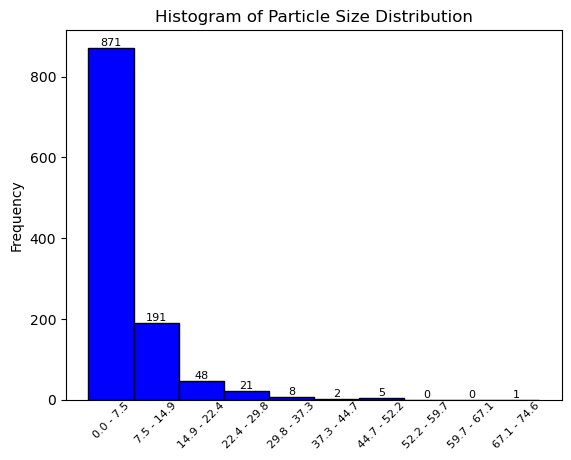

In [3]:
import cv2, os, math
import numpy as np
from utils.visualize import VisualizeData
from utils.tools import Tools

os.environ['KMP_DUPLICATE_LIB_OK']='True'

# 使用粒径来进行筛出颗粒，首先先标注所有颗粒的粒径
def projected_area_diameter(area):
    return math.sqrt((4 * area) / math.pi)

def mark_diameter_of_contour(contours, ori_img):
    # 创建一个空白图像用于绘制轮廓和标注
    marked_img = np.zeros((ori_img.shape[0], ori_img.shape[1], 3), dtype=np.uint8)

    offset_x, offset_y = -15, 5

    # 绘制填充轮廓并标注面积
    if contours:
        for contour in contours:
            # 绘制填充轮廓
            cv2.drawContours(marked_img, [contour], -1, (255, 255, 255), thickness=cv2.FILLED)
            # 计算轮廓面积, contour的size代表轮廓中点的数量，轮廓点x2就是size，和轮廓长度没有关系
            area = cv2.contourArea(contour)
            diameter = projected_area_diameter(area)

            # 计算轮廓的质心
            M = cv2.moments(contour)
            if M["m00"] != 0:
                cX = int(M["m10"] / M["m00"])
                cY = int(M["m01"] / M["m00"])
            else:
                cX, cY = 0, 0

            # 标注面积
            cv2.putText(marked_img, f"{int(diameter)}", (cX+offset_x, cY+offset_y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)
    else:
        print("No contours found")
    
    return marked_img

def statstics_diameter_hist(contours):
    hist = []
    for contour in contours:
        # 计算轮廓面积, contour的size代表轮廓中点的数量，轮廓点x2就是size，和轮廓长度没有关系
        area = cv2.contourArea(contour)
        diameter = projected_area_diameter(area)
        hist.append(diameter)
    return hist

# 通过粒径的大小对图像进行筛选
def filter_by_diameter(contours, ori_img, diameter_interval):
    # 创建一个空白图像用于绘制筛选后的轮廓
    filtered_image = np.zeros_like(ori_img)
    diameter_min, diameter_max = diameter_interval[0], diameter_interval[1]
    # 筛选轮廓并绘制
    for contour in contours:
        area = cv2.contourArea(contour)
        contour_diameter = projected_area_diameter(area)
        if contour_diameter >= diameter_min and contour_diameter <= diameter_max:
            cv2.drawContours(filtered_image, [contour], -1, (255), thickness=cv2.FILLED)
        else:
            # 将小于阈值的轮廓设置为背景色（即0）
            cv2.drawContours(filtered_image, [contour], -1, (0), thickness=cv2.FILLED)
    
    return filtered_image

# 基于轮廓得到代表性的最小粒径大小（从最大颗粒开始，往前的20个作为选择的目标）
def get_typical_particle_diameter(contours, quantile):
    diameter_array = []
    # 计算并打印每个轮廓的面积
    for i, contour in enumerate(contours):
        area = cv2.contourArea(contour)
        diameter_array.append(Tools.projected_area_diameter(area))
    
    sorted_arr = sorted(diameter_array, reverse=True)
    max_diameter = math.ceil(sorted_arr[0])
    min_diameter = math.floor(sorted_arr[quantile - 1])

    return [min_diameter, max_diameter]

parent = "D:/workspace/ml-workspace/registration/datasets/sample4/bse/s1/100"
# 2: 读取一个二值化BSE
r_path = f"{parent}/4-1-1-ct-masked-filled.bmp"
bin_bse = cv2.imread(r_path, cv2.IMREAD_GRAYSCALE)

# 3: 绘制二值图像的对象的轮廓，
# 查找轮廓
contours, hierarchy = cv2.findContours(bin_bse, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# 创建一个空白图像用于绘制轮廓
contour_image = np.zeros_like(bin_bse)
# 绘制轮廓
cv2.drawContours(contour_image, contours, -1, (255, 255, 255), 2)

# 填充轮廓里的内容，不像之前那样不进行填充，这样其实有利于匹配（部分的噪声带来了错误的分割和成像）
fill_contour_img = np.zeros_like(bin_bse)
cv2.drawContours(fill_contour_img, contours, -1, (255, 255, 255), thickness=cv2.FILLED)

# 4：统计BSE的区域面积
marked_contour_img = mark_diameter_of_contour(contours, bin_bse)

# 5: 统计粒径分布图
diameter_hist = statstics_diameter_hist(contours)

# 把这个问题叙述清楚，然后交给GPT给出其原理和方法，使用分位数法
total_white_num = np.sum(fill_contour_img == 255)

aim_dist_diameter = get_typical_particle_diameter(contours, 20)

filtered_img = filter_by_diameter(contours, contour_image, [aim_dist_diameter[0], aim_dist_diameter[1]])

print(f"aim_dist_diameter: {aim_dist_diameter}")

import matplotlib.pyplot as plt

def show_particle_accum_dist(diameter_hist):
    # 使用 numpy.histogram 划分数据并获取频数
    diameter_n, diameter_bins = np.histogram(diameter_hist, bins=10)
    temp = 0
    num_accum = []
    label_accum = []

    for i in range(len(diameter_n)):
        index = -(i+1)
        num = diameter_n[index]
        temp += num
        num_accum.append(temp)
        bin_left = diameter_bins[index]
        bin_right = diameter_bins[index - 1]
        label = f'{bin_left:.1f} - {bin_right:.1f}'
        label_accum.append(label)

    # 反转数组
    num_accum.reverse()
    plt.xticks([])
    # 计算每个 bin 的中心位置
    bin_centers = [(diameter_bins[i] + diameter_bins[i + 1]) / 2 for i in range(len(diameter_bins) - 1)]
    # 绘制直方图
    plt.bar(bin_centers, num_accum, width=5.0, edgecolor='black', align='center')
    for i in range(len(num_accum)):
        plt.text(bin_centers[i], -0.1, label_accum[-(i+1)], ha='center', va='top', rotation=45, fontsize=8, color='black')
        plt.text(bin_centers[i], num_accum[i], str(num_accum[i]), ha='center', va='bottom')

    # 添加标题和标签
    plt.title('Particle dist Histogram')

def show_particle_dist(diameter_hist, bins=10):
    # 绘制直方图
    n, bins, patches = plt.hist(diameter_hist, bins, color='blue', edgecolor='black')

    # 在每个 bin 上显示对应的数值
    # 在每个 bin 上显示对应的左右边界
    # 隐藏X轴的刻度

    plt.xticks([])
    for i in range(len(n)):
        bin_left = bins[i]
        bin_right = bins[i + 1]
        bin_center = (bin_left + bin_right) / 2
        label = f'{bin_left:.1f} - {bin_right:.1f}'
        plt.text(bin_center, -0.1, label, ha='center', va='top', rotation=45, fontsize=8, color='black')
         # 标注 bin 的数值
        plt.text(bin_center, n[i], str(int(n[i])), ha='center', va='bottom', fontsize=8, color='black')

    # 添加标题和标签
    plt.title('Histogram of Particle Size Distribution')
    # plt.xlabel('Particle Size') # x坐标
    plt.ylabel('Frequency')

def show_particle_hist_by_binsnum(diameter_hist, interval_num):
    show_particle_dist(diameter_hist, interval_num)

def show_particle_hist_by_bins(diameter_hist, diameter_range, step):
    min_val = diameter_range[0]
    max_val = diameter_range[1]
    # 生成固定间隔的数组
    bins = np.arange(min_val, max_val + step, step)
    show_particle_dist(diameter_hist, bins)


# Tools.save_img(parent, "4-1-1-ct-masked-filled.bmp", fill_contour_img)

# show_particle_hist_by_bins(diameter_hist, [0, 75], 10)
show_particle_hist_by_binsnum(diameter_hist, 10)

mean_diameter = np.mean(diameter_hist)

print(f"mean diamter1: {mean_diameter}")
print(f"mean diamter2: {Tools.get_mean_diameter_bin_img(bin_bse)}")

# plt.subplot(1, 1, 1)
# plt.title("Original Image")
# plt.imshow(marked_contour_img)
# plt.show()
# VisualizeData.show_image(image=marked_contour_img, gray=False)
# VisualizeData.show_imgs(
#     imgs = [bin_bse, contour_image, fill_contour_img, filtered_img,marked_contour_img],
#     imgs_name = ["ori", "contours", "fill_contours", "filtered_img", "marked img"],
#     gray = [True, True, True, True, False]
# )

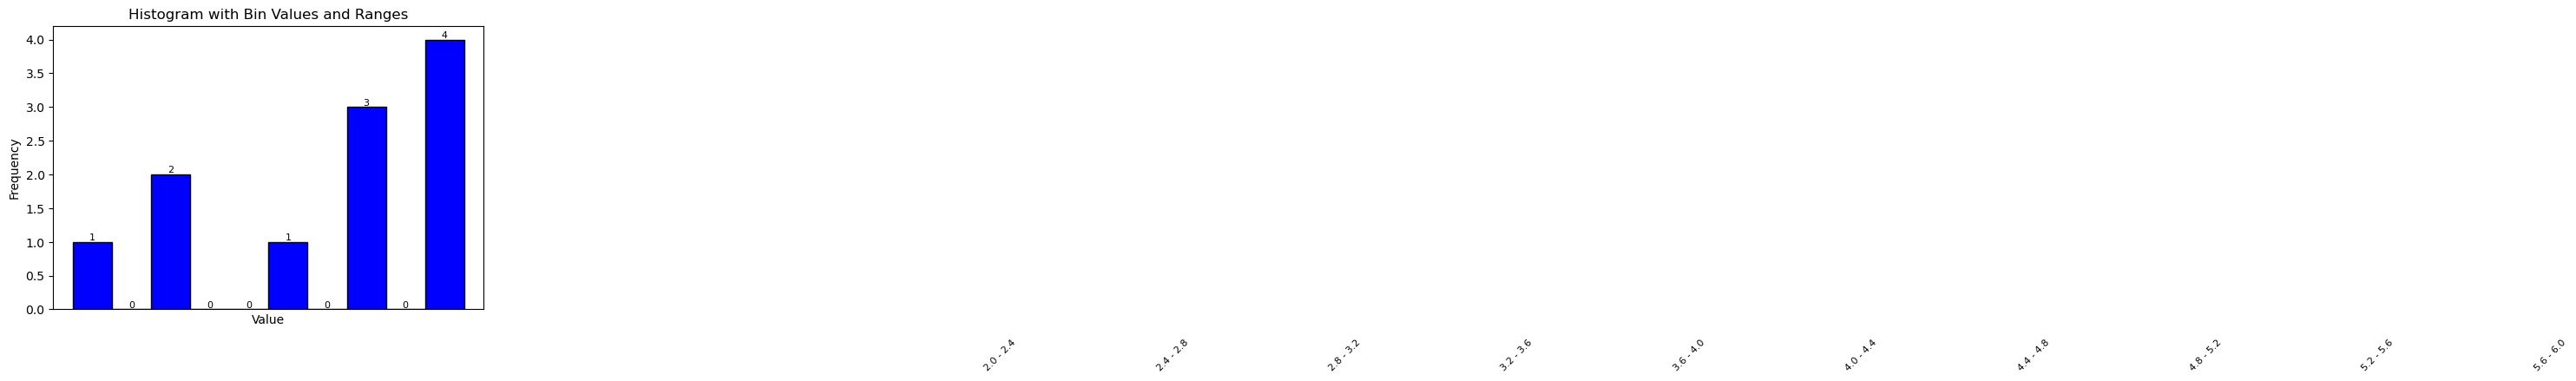

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# 示例数据
x = np.array([1, 2, 2, 3, 4, 4, 4, 5, 5, 5, 5])
y = np.array([2, 3, 3, 4, 5, 5, 5, 6, 6, 6, 6])

# 使用 numpy.histogram 计算直方图
bins = 10  # 设置 bins 的数量
hist, bin_edges = np.histogram(y, bins=bins)

# 绘制直方图
plt.hist(y, bins=bin_edges, color='blue', edgecolor='black')

# 隐藏X轴的刻度
plt.xticks([])

# 在每个 bin 上显示对应的左右边界和频数
for i in range(len(hist)):
    bin_left = bin_edges[i]
    bin_right = bin_edges[i + 1]
    bin_center = (bin_left + bin_right) / 2
    # 标注 bin 的左右边界
    label = f'{bin_left:.1f} - {bin_right:.1f}'
    plt.text(bin_center, -0.1, label, ha='center', va='top', rotation=45, fontsize=8, color='black', transform=plt.gca().transAxes)
    # 标注 bin 的数值
    plt.text(bin_center, hist[i], str(int(hist[i])), ha='center', va='bottom', fontsize=8, color='black')

# 添加标题和标签
plt.title('Histogram with Bin Values and Ranges')
plt.xlabel('Value')
plt.ylabel('Frequency')

# 调整图像的下边距以显示所有文本
plt.subplots_adjust(bottom=0.2)

# 显示图像
plt.show()
